## Variational AutoEncoder (VAE): an algorithm to work with distributions

This notebook deals with generating an `Autoencoder` model to learn the underlying distribution of the data. To do this we have to modify the autoencoder such that the `encoder` does not learn a compressed representation of the input data, but rather it will learn the parameters of the distribution of the data in the latent (compressed) space. 

So the idea is to start from an observed sample of the distribution of the data $P({\bf X})$ and to pass this to the `encoder` which will reduce its dimensionality, i.e. $P({\bf X})\mapsto P'({\bf X}_{\rm c})$ where ${\bf X}\in\mathrm{R}^m$ and ${\bf X}_{\rm c}\in\mathrm{R}^n$ with $n<m$. In other words, in a VAE the `encoder` step does not represent the input data ${\bf X}$ with a `code` ${\bf X}_{\rm c}$, but rather the initial data distribution $P({\bf X})$ with a compressed distribution $P'({\bf X}_{\rm c})$, which we usually need to approximate in some analytic form, e.g. a multi-variate normal $P'({\bf X}_{\rm c})\sim \mathcal{N}(\mu,\Sigma)$.

In [1]:
#| code-fold: true
import numpy as np
import matplotlib.pylab as plt
from scipy.special import i0, i1, k0, k1
from torch import tensor
from torch import nn
from torch.nn import functional as F
import torch, math
import random
import corner

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

In [2]:
#| code-fold: true
G, H, Dc = 4.301e-9, 70, 200.

def fc(x):
    return np.log(1+x)-x/(1+x)

def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

In [3]:
#| code-fold: true

# halo concentration--mass relation
def c(Mh, w_scatter=False, H=70.): 
    if w_scatter: return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12) + rng.normal(0.0, 0.11, len(Mh)))
    return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12))

# disc mass--size relation
def getRd_fromMd(Md, w_scatter=False):
    ''' approximate mass-size relation '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.3+0.5 + rng.normal(0.0, 0.4, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.3+0.5)

# disc mass--halo mass relation
def getMh_fromMd(Md, w_scatter=False):
    ''' approximate SHMR '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.75+12.0 + rng.normal(0.0, 0.25, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.75+12.0)

In [4]:
#| code-fold: true
class curveMod():
    def __init__(self, Md, Rd, Mh, cc, rad=np.logspace(-1, np.log10(50), 50)):
        self.G, self.H, self.Dc = 4.301e-9, 70, 200.  # physical constants
        self.Md, self.Rd = Md, Rd
        self.Mh, self.cc = Mh, cc
        self.rad = rad
        
        if hasattr(self.Md, '__len__'):
            self.vdisc = [self._vdisc(self.rad, self.Md[i], self.Rd[i]) for i in range(len(self.Md))]
            self.vdm   = [self._vhalo(self.rad, self.Mh[i], self.cc[i]) for i in range(len(self.Md))]
            self.vc    = [np.sqrt(self.vdisc[i]**2+self.vdm[i]**2) for i in range(len(self.Md))]
        else:
            self.vdisc = self._vdisc(self.rad, self.Md, self.Rd)
            self.vdm   = self._vhalo(self.rad, self.Mh, self.cc)
            self.vc    = np.sqrt(self.vdisc**2+self.vdm**2)
        
    def _fc(self, x): return np.log(1+x)-x/(1+x)
    def _Vvir(self, Mh): return np.sqrt((self.Dc*(self.H)**2/2)**(1./3.) * (self.G*Mh)**(2./3.))
    def _Rvir(self, Mh): return 1e3 * (Mh / (0.5*self.Dc*self.H**2 /self.G))**(1./3.)
    
    def _vhalo(self, R, Mh, cc):
        # circular velocity of the halo component (NFW model)
        rv = self._Rvir(Mh)
        return np.sqrt(self._Vvir(Mh)**2*rv/R*self._fc(cc*R/rv)/self._fc(cc)) 
    
    def _vdisc(self, R, Md, Rd):
        # circular velocity of the disc component (exponential disc)
        y = R/2./Rd
        return np.nan_to_num(np.sqrt(2*4.301e-6*Md/Rd*y**2*(i0(y)*k0(y)-i1(y)*k1(y))))

Let's start again by generating the distribution of physical parameters and calculating the rotation curve of a galaxy with those parameters. This part is taken from the [blog post on Autoencoders](https://lposti.github.io/MLPages/neural%20network/autoencoder/basics/jupyter/2022/10/13/autoencoder_rotcurves.html) so I just refer to that for details.

In [5]:
nsamp = 2000
ms = 10**rng.uniform(9, 12, nsamp)
rd = getRd_fromMd(ms, w_scatter=True)
mh = getMh_fromMd(ms, w_scatter=True)
cc = c(mh, w_scatter=True)

In [6]:
cm=curveMod(ms,rd,mh,cc)

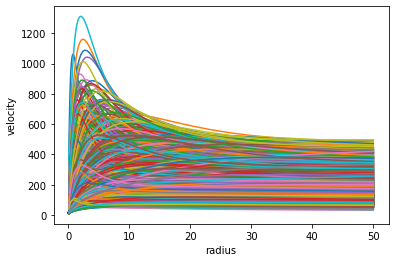

In [7]:
for v in cm.vc: plt.plot(cm.rad, v)
plt.xlabel('radius')
plt.ylabel('velocity');

This plot shows a random realization of `nsamp` rotation curves from our physical model. These curves are the dataset the we are going to use to train our Variational Autoencoder. Let's start by normalizing the data and defining the training and validation sets.

In [8]:
def datanorm(x):  return (x-x.mean())/x.std(), x.mean(), x.std()
def datascale(x, m, s): return x*s+m

idshuff = torch.randperm(nsamp)
xdata = tensor(cm.vc, dtype=torch.float)[idshuff,:]
xdata, xmean, xstd = datanorm(xdata)

fval = 0.20
xtrain = xdata[:int(nsamp*(1.0-fval))]
xvalid = xdata[int(nsamp*(1.0-fval)):]

/Users/lposti/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/torch/csrc/utils/tensor_new.cpp:204.)
  """


## The Variational Autoencoder

We now build the class, deriving from `nn.Module`, for our Variational AutoEncoder (VAE). In particular, we define the layers in the `__init__` method and we define an `encoder` and a `decoder` method, just as we did for the Autoencoder. However, this class is quite a lot richer than the one we used for and Autoencoder and we will go through each method below. 

In [9]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, ninp, **kwargs):
        super().__init__()
        self.encodeLayer1 = nn.Sequential(nn.Linear(in_features=ninp, out_features=32), nn.ReLU())
        self.encodeLayer2 = nn.Sequential(nn.Linear(in_features=32,   out_features=16), nn.ReLU())
        self.encodeOut    = nn.Linear(in_features=16,   out_features=8)
        self.decodeLayer1 = nn.Sequential(nn.Linear(in_features=4,    out_features=16), nn.ReLU())
        self.decodeLayer2 = nn.Sequential(nn.Linear(in_features=16,   out_features=32), nn.ReLU())
        self.decodeOut    = nn.Linear(in_features=32,   out_features=ninp)
        self.ELBO_loss = None
        
    def encoder(self, x):       
        mean, logvar = torch.split(self.encodeOut(self.encodeLayer2(self.encodeLayer1(x))),4,dim=1)
        return mean, logvar
    
    def decoder(self, encoded): return self.decodeOut(self.decodeLayer2(self.decodeLayer1(encoded)))
    
    def reparametrize(self, mean, logvar):
        eps = tensor(rng.normal(size=mean.shape), dtype=torch.float)
        return eps * torch.exp(logvar * 0.5) + mean # exp(0.5logvar) = std
    
    # https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
    # https://arxiv.org/pdf/1312.6114.pdf
    # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes?noredirect=1&lq=1
    def _ELBO(self, x, decoded, mean, logvar):
        mseloss = nn.MSELoss(reduction='sum')
        logpx_z = -mseloss(x, decoded)
        KLdiv = -0.5 * torch.sum(1 + logvar - mean ** 2 - logvar.exp(), dim = 1)
        return (KLdiv - logpx_z).mean()
        
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        decoded = self.decoder(z)
        self.ELBO_loss = self._ELBO(x, decoded, mean, logvar)
        
        return decoded
    
    def getELBO_loss(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        decoded = self.decoder(z)
        return self._ELBO(x, decoded, mean, logvar)
        

Ok, so there's a lot to break down here!

- First of all, we notice that the overall structure of the encoder/decoder network is relatively similar to the `autoencoder` we saw before, with the important difference that the encoder now returns 8 parameters instead of 4. These are the parameters of the multi-variate normal distribution with which we represent the 4-dimensional latent space, so mean and variance for each of the four physical properties that generate the rotation curves. Thus, the encoder step does not output a `code`, but means and variances for each physical property.
- the decoder step is instead totally similar to a simple `autoencoder` and in fact it requires a `code` as an input. In order to generate a code from the means and variances that come out of the encoder phase without breaking the backprop flow of the algorithm, [Kingma & Welling (2013)](https://arxiv.org/pdf/1312.6114.pdf) proposed to use a *reparametrization trick*, which consists of throwing a new sample from a standard normal and then shifting this to have the same mean and variance as given by the encoder.
- the `forward` method of this class follows these steps: the encoder gives means and variances of the latent space, the reparametrization trick is used to generate a `code`, which is finally decoded by the decoder.
- the appropriate loss function for a variational autoencoder is the **Evidence Lower BOund [(ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)**. In fact, minimising the -ELBO means maximising a lower bound on the evidence or likelihood of the model. The evidence, or reconstruction loss, is `logpx_z` which is just an `MSE` loss on the data and the decoded output of the autoencoder. This term encourages the reconstruction of the dataset and tends to prefer separated encodings for each element of the dataset. The other term, `KLdiv`, is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) of the proposed distribution in the latent space with the likelihood. This term has the opposite effect of promoting overlapping encodings for separate observations. For this reason, maximising ELBO guarantees to achieve a nice compromise between representing the original data and the ability to generalize by generating *realistic* new data.

With these changes our neural network is now capable of constructing an approximation for the distribution of the four physical parameters in the latent space. We can now run the usual optimization algorithm and start training this model.

In [10]:
vae = VariationalAutoEncoder(len(cm.rad))

# Adam and ELBO Loss
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

for epoch in range(2000):
    ymod = vae.forward(xtrain)
    loss = vae.ELBO_loss
    
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
#     print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % vae.getELBO_loss(xvalid))
    if epoch%100==0: print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % vae.getELBO_loss(xvalid))

0 train L:8.46e+04   valid L:1.76e+04
100 train L:1.29e+03   valid L:3.67e+02
200 train L:5.40e+02   valid L:1.73e+02
300 train L:4.72e+02   valid L:1.39e+02
400 train L:1.42e+02   valid L:6.75e+01
500 train L:1.19e+02   valid L:5.85e+01
600 train L:9.75e+01   valid L:5.35e+01
700 train L:1.05e+02   valid L:5.57e+01
800 train L:7.98e+01   valid L:4.68e+01
900 train L:1.91e+02   valid L:7.53e+01
1000 train L:7.49e+01   valid L:4.26e+01
1100 train L:8.18e+01   valid L:4.40e+01
1200 train L:6.40e+01   valid L:3.92e+01
1300 train L:6.89e+01   valid L:3.86e+01
1400 train L:6.15e+01   valid L:3.69e+01
1500 train L:6.42e+01   valid L:3.66e+01
1600 train L:5.76e+01   valid L:3.55e+01
1700 train L:5.99e+01   valid L:3.60e+01
1800 train L:1.28e+02   valid L:5.11e+01
1900 train L:4.93e+01   valid L:3.26e+01


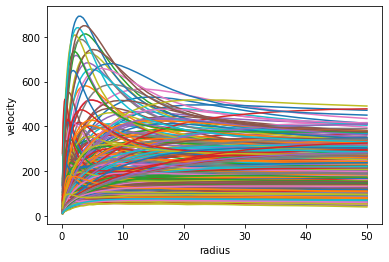

In [11]:
for v in datascale(vae.forward(xvalid),xmean,xstd): plt.plot(cm.rad, v.detach().numpy())
plt.xlabel('radius')
plt.ylabel('velocity');

The plot above shows the distribution of rotation curves that the VAE has learned. We can see that there is a quite large variety of rotation curve shapes that can be represented by this model. Notice that the region in the radius-velicity space covered by the VAE is indeed quite similar to that of the training set (see plot above).

This shows that the VAE has indeed learned an effective distribution in the latent space which generates the rotation curve dataset we started from.

In [77]:
#| include: false
# vae.encoder(xtrain)[0].mean(dim=0).detach(), vae.encoder(xtrain)[0].std(dim=0).detach()
vae.encoder(xtrain)[1].mean(dim=0).detach(), vae.encoder(xtrain)[1].std(dim=0).detach()

(tensor([-9.8644, -9.2065, -9.2729, -9.5192]),
 tensor([2.6596, 2.2083, 2.5054, 2.8524]))

### Exploring the latent space distribution

We can now have a look at what the VAE has learned about the latent space. To do so, we can take the means and variances derived by the `encoder` on the training set and we can use them to generate samples on the latent space. Basically for each $x_i$ in the training set we get a $\mu_i$ and a $\sigma^2_i$ and we draw 100 samples from $\mathcal{N}(\mu_i, \sigma^2_i)$.

In [12]:
msm, lvsm = vae.encoder(xtrain)[0].detach(), vae.encoder(xtrain)[1].detach()
# the above are the means and variances obtained by the encoder

ns = 100
sss = tensor(rng.normal(size=(ns, 4)), dtype=torch.float) * torch.exp(lvsm[0] * 0.5) + msm[0]
for i in range(1, msm.shape[0]):
    sss = torch.vstack((sss, tensor(rng.normal(size=(ns, 4)), dtype=torch.float) * torch.exp(lvsm[i] * 0.5) + msm[i]))
print (sss.shape)

torch.Size([160000, 4])


We thus have an array of training_set_size x N_samples = 1600 x 100 = 160000 samples generated from the distribution inferred by the VAE on the latent space. Let's now plot them (I'm using [corner](https://corner.readthedocs.io/en/latest/) to do so)

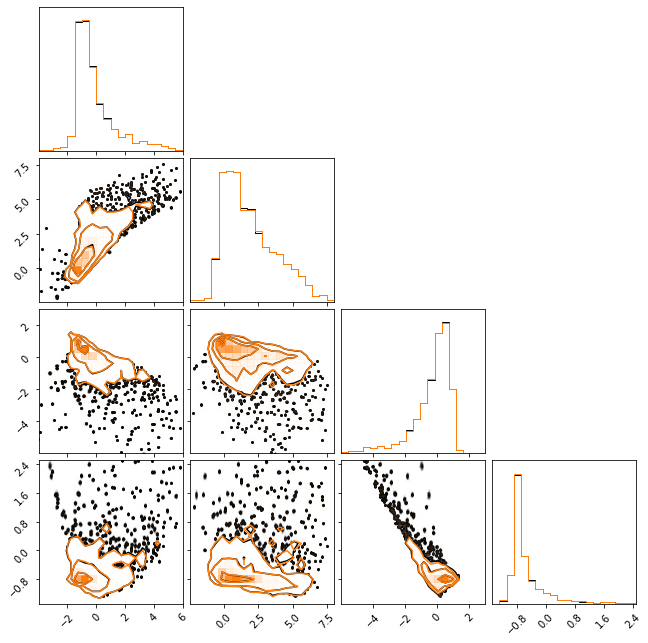

In [14]:
rr = ((-4,6),(-2.5,8.0),(-6,3),(-1.5,2.5))
fig = corner.corner(sss.numpy(), range=rr, hist_kwargs={"density":True});
fig = corner.corner(msm.numpy(), range=rr, color='C1', fig=fig, hist_kwargs={"density":True});

Here in black we plotted the resulting samples of the latent space as described above, while in orange we overplot just the means $\mu_i$ for each element in the training set. It turns out that the distribution of the means (in orange) is virtually identical to that derived from sampling each multi-variate Gaussian in the latent space (in black). 

This implies that the variances $\sigma^2_i$ that are the output of the `encoder` are generally quite small and that the *VAE effectively reconstructs the distribution of the latent space by superimposing many thin Gaussians, all with slightly different mean and small variance*. In fact, one could interpret the orange distribution as a superposition of Dirac deltas centered at each mean derived by the `encoder` on the training set, i.e. $\sum_i\delta_i(x-\mu_i)$.

Let's now plot together the physical parameters that we used to generate each rotation curve in the training set, together with the means derived by the `encoder` step on each element of that set. This allows us to explore whether there are any correlations between the original 4 physical parameters and the 4 dimensions of the latent space constructed by the VAE.

To do this we can stack together the tensor of physical parameters and that of the means.

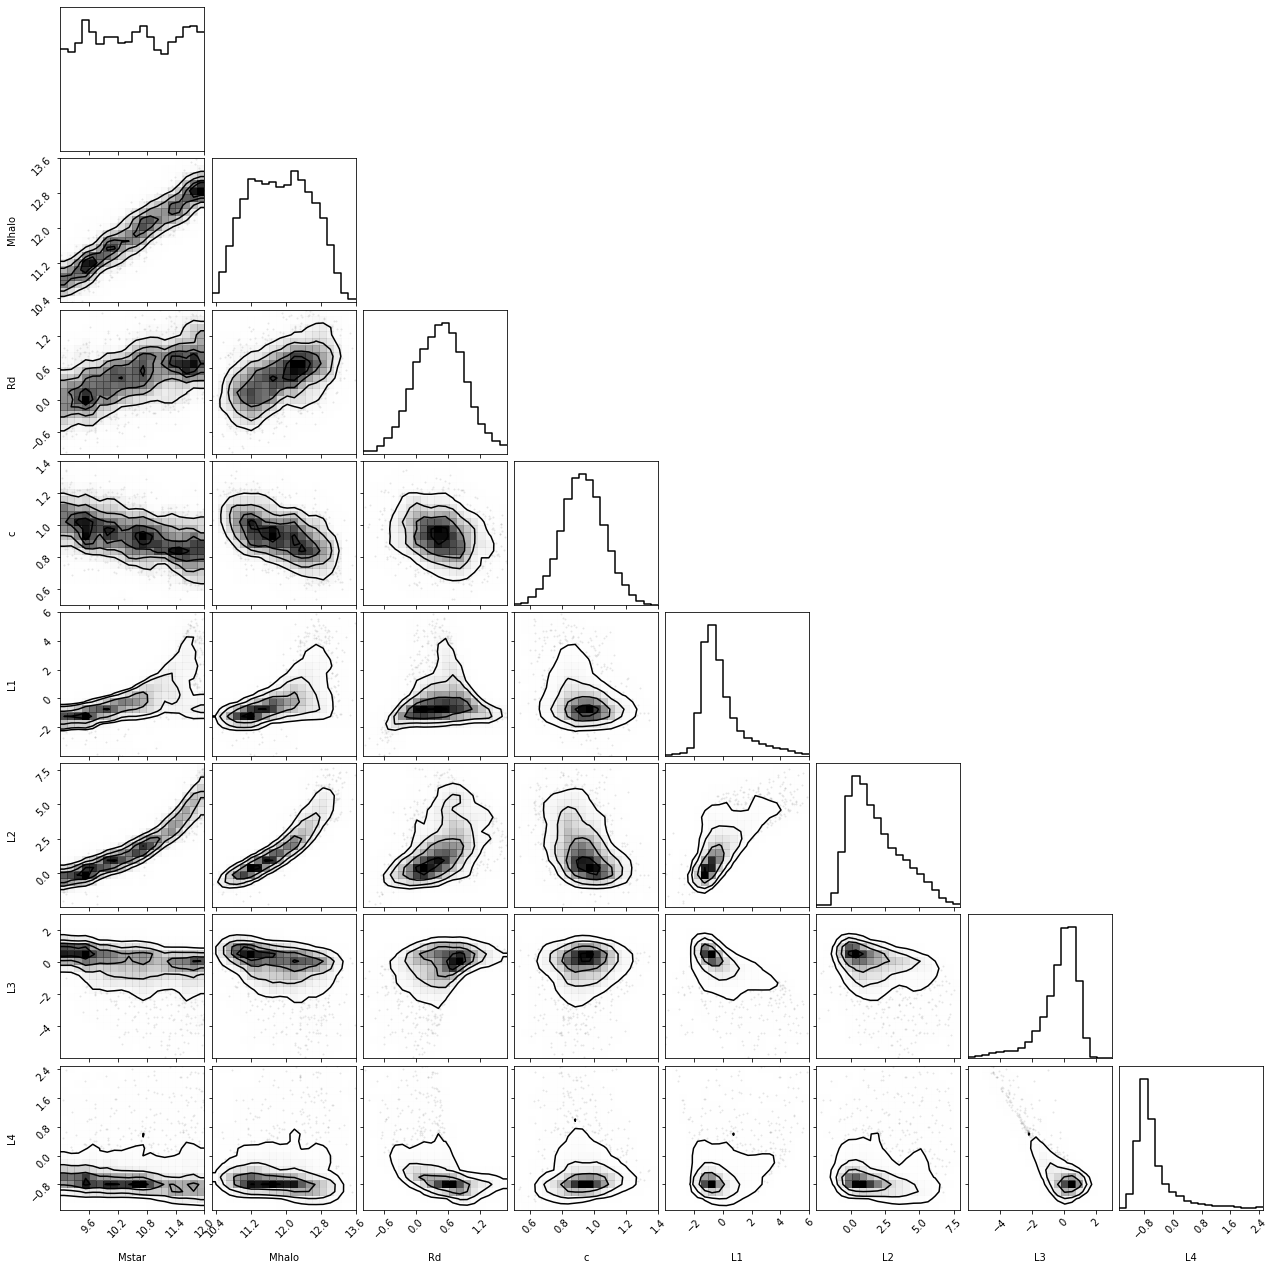

In [15]:
mdshuff, mhshuff = [cm.Md[i] for i in idshuff], [cm.Mh[i] for i in idshuff]
rdshuff, ccshuff = [cm.Rd[i] for i in idshuff], [cm.cc[i] for i in idshuff]
mdtrain, mhtrain = mdshuff[:int(nsamp*(1.0-fval))], mhshuff[:int(nsamp*(1.0-fval))]
rdtrain, cctrain = rdshuff[:int(nsamp*(1.0-fval))], ccshuff[:int(nsamp*(1.0-fval))]

# physical parameters corresponding to each element of the training set
partrain = (np.vstack([mdtrain, mhtrain, rdtrain, cctrain]).T)

# stacking the tensor of phsyical parameters with that of the means derived by the encoder
dd = torch.hstack((torch.from_numpy(np.log10(partrain)), msm)).numpy()

rr2 = ((9,12),(10.3,13.6),(-1.0,1.7),(0.5,1.4),(-4,6),(-2.5,8.0),(-6,3),(-1.5,2.5))
ll  = ['Mstar', 'Mhalo', 'Rd', 'c', 'L1', 'L2', 'L3', 'L4']
corner.corner(dd, range=rr2, smooth=0.75, smooth1d=0.75, labels=ll);

Ok, now this corner plot has a lot of information...let's breakdown the most important ones:

- the first 4 blocks of this corner plot are relative to the physical parameters `(ms,mh,rd,cc)` and show the marginal distribution of each of these parameters and how they are correlated with each other.
- the last 4 blocks, instead, are relative to the 4 latent parameters `(L1,L2,L3,L4)`, and again show the marginal distribution of each and their mutual correlations - this is equivalent to the corner plot just above (in that case this was plotted in orange colour)
- the 4x4 sub-block on the lower-left corner is possibly the most interesting one as it is the "mixed" block that highlights the relation between the physical and latent parameters. Each of these 16 panels show the correlation of one of the physical parameters with one of the latent ones. We can see that there are several significant correlations (e.g. `ms-L1`, `mh-L2`, `rd-L3`), meaning that these two sets are not independent.

### Generating new realistic data

Now that we have a working approximation of the distribution in the latent space it is easy to use the VAE to generate new rotation curves. We will showcase now a quite simplistic way to do it, which is by assuming that we can represent the latent space with a 4-dimensional Gaussian, even though we have seen in the plots above that the actual distribution is more complex.

We consider the means $\mu_i$ that the `encoder` derives for the full training set and we take the mean and standard deviation of these. We use these two parameters to define a normal distribution

In [16]:
size=500

dd = torch.distributions.normal.Normal(msm.mean(dim=0), msm.std(dim=0))
new_code = dd.sample(torch.Size([size]))

Let's make a comparison by plotting the marginalised distributions of the 4 latent parameters with that of the normal distribution that we are assuming

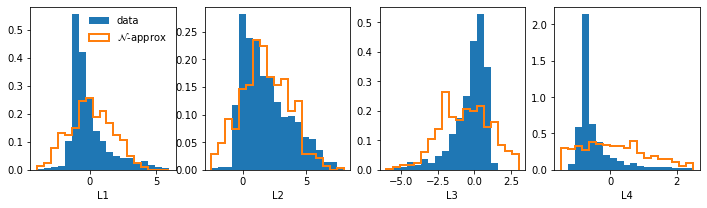

In [29]:
fig,ax = plt.subplots(figsize=(12,3), ncols=4)

bins=[np.linspace(rr[0][0],rr[0][1],20), np.linspace(rr[1][0], rr[1][1],20), 
      np.linspace(rr[2][0],rr[2][1],20), np.linspace(rr[3][0], rr[3][1],20)]
for i in range(4):
    ax[i].hist(msm[:,i].numpy(), bins=bins[i], density=True, label='data');
    ax[i].hist(new_code[:,i].numpy(), bins=bins[i], histtype='step', lw=2, density=True, 
               label='$\mathcal{N}$'+'-approx');
    if i==0: ax[i].legend(loc='upper right', frameon=False)
    ax[i].set_xlabel('L%1d'%(i+1))

Quite a big difference!

However, this is not an issue since we are just using a normal distribution since it is convenient to sample and for us it is just a means to generate plausible code to be interpreted by the `decoder`. As a matter of fact, by doing this we are able to generate quite a new variety of possible galaxy rotation curves.

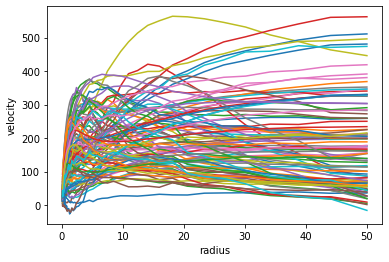

In [18]:
fig,ax = plt.subplots(figsize=(6,4))
for v in datascale(vae.decoder(new_code),xmean,xstd)[:100]: ax.plot(cm.rad, v.detach().numpy())
ax.set_xlabel('radius')
ax.set_ylabel('velocity');

With a bit on work on the reparametrization trick, we can relax the assumption that the distribution in the latent space is of a multi-variate, but uncorrelated, normal. In practice, instead of having just 4 means and 4 variances as output of the `encoder` step, we also add 6 covariances, so that we can define the full non-zero covariance matrix of the multi-variate normal in the latent space.

Unfortunately this require quite a bit more math on the reparametrization trick, which is not anymore just $\epsilon*\sigma+\mu$, but where the full covariance matrix is used. This calculation requires, among other things, to derive the square root of a matrix, for which we employ the SVD decomposition: if $A = U\,{\rm diag}(s)\,V^{\rm T}$, where $A, U, V \in \mathbb{R}^{n, n}$, $s\in\mathbb{R}^n$, and diag$(s)$ is a diagonal matrix with the elements of $s$ as diagonal, then $\sqrt{A} = U\,{\rm diag}\left(\sqrt{s}\right)\,V^{\rm T}$.

In [112]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, ninp, **kwargs):
        super().__init__()
        self.encodeLayer1 = nn.Linear(in_features=ninp, out_features=32)
        self.encodeLayer2 = nn.Linear(in_features=32,   out_features=16)
        self.encodeOut    = nn.Linear(in_features=16,   out_features=14)
        self.decodeLayer1 = nn.Linear(in_features=4,    out_features=16)
        self.decodeLayer2 = nn.Linear(in_features=16,   out_features=32)
        self.decodeOut    = nn.Linear(in_features=32,   out_features=ninp)
        self.ELBO_loss = None
        
    def encoder(self, x):       
        mean, logvar, covs = torch.split(self.encodeOut(F.relu(self.encodeLayer2(F.relu(self.encodeLayer1(x))))), 
                                         [4, 4, 6], dim=1)
        return mean, logvar, covs
    
    def decoder(self, encoded): return self.decodeOut(F.relu(self.decodeLayer2(F.relu(self.decodeLayer1(encoded)))))
    
    def reparametrize(self, mean, m_cov):
        eps = tensor(rng.normal(size=mean.shape), dtype=torch.float)
#         return eps * var.sqrt() + mean
        
        # find matrix square root with SVD decomposition
        # https://math.stackexchange.com/questions/3820169/a-is-a-symmetric-positive-definite-matrix-it-has-square-root-using-svd?noredirect=1&lq=1
        U,S,V = torch.svd(m_cov)                                             # A       = U diag(S) V.T
        dS = torch.stack([torch.diag(S[i,:]) for i in range(S.shape[0])])    # sqrt(A) = U diag(sqrt(S)) V.T
        cov_sqrt = torch.einsum('bij,bkj->bik',torch.einsum('bij,bjk->bik',U,dS.sqrt()),V)
        return torch.einsum('bij,bi->bj', cov_sqrt, eps) + mean 
    
    def _ELBO(self, x, decoded, mean, m_cov, var):
        mseloss = nn.MSELoss(reduction='sum')
        logpx_z = -mseloss(x, decoded)
        KLdiv = -0.5 * (torch.log(m_cov.det()) + 4 - torch.sum(mean**2 + var, dim = 1))
        return torch.mean((KLdiv - logpx_z)[~(KLdiv - logpx_z).isnan()])  # torch.nanmean
    
    def _get_m_cov(self, logvar, covs):
        # covariance matrix
        m_cov = torch.zeros(logvar.shape[0], 4, 4)
        m_cov[:,[0,1,2,3],[0,1,2,3]] = logvar.exp()
        m_cov[:,[0,0,0,1,1,2],[1,2,3,2,3,3]] = covs
        m_cov[:,[1,2,3,2,3,3],[0,0,0,1,1,2]] = covs
#         var = torch.einsum('bii->bi', m_cov)
        return m_cov, logvar.exp()
        
    def forward(self, x):
        mean, logvar, covs = self.encoder(x)
        m_cov, var = self._get_m_cov(logvar, covs)
        z = self.reparametrize(mean, m_cov)
        decoded = self.decoder(z)
        self.ELBO_loss = self._ELBO(x, decoded, mean, m_cov, var)
        
        return decoded
    
    def getELBO_loss(self, x):
        mean, logvar, covs = self.encoder(x)
        m_cov, var = self._get_m_cov(logvar, covs)
        z = self.reparametrize(mean, m_cov)
        decoded = self.decoder(z)
        return self._ELBO(x, decoded, mean, m_cov, var)

In [113]:
vae = VariationalAutoEncoder(len(cm.rad))

# Adam and ELBO Loss
optimizer = torch.optim.Adam(vae.parameters(), lr=0.4e-2)

for epoch in range(1000):
    ymod = vae.forward(xtrain)
    loss = vae.ELBO_loss
    
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
#     print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % vae.getELBO_loss(xvalid))
    if epoch%50==0: print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % vae.getELBO_loss(xvalid))

0 train L:8.26e+04   valid L:2.21e+04
50 train L:6.80e+03   valid L:1.42e+03
100 train L:1.47e+03   valid L:4.22e+02
150 train L:9.56e+02   valid L:2.77e+02
200 train L:7.22e+02   valid L:1.98e+02
250 train L:5.99e+02   valid L:2.26e+02
300 train L:4.56e+02   valid L:1.53e+02
350 train L:4.18e+02   valid L:1.85e+02
400 train L:3.63e+02   valid L:1.66e+02
450 train L:3.53e+02   valid L:1.57e+02
500 train L:3.33e+02   valid L:1.39e+02
550 train L:4.32e+02   valid L:1.75e+02
600 train L:3.07e+02   valid L:1.39e+02
650 train L:3.10e+02   valid L:1.10e+02
700 train L:2.77e+02   valid L:1.09e+02
750 train L:9.70e+02   valid L:3.07e+02
800 train L:6.58e+02   valid L:3.33e+02
850 train L:4.97e+02   valid L:2.41e+02
900 train L:4.53e+02   valid L:1.82e+02
950 train L:6.56e+02   valid L:3.57e+02


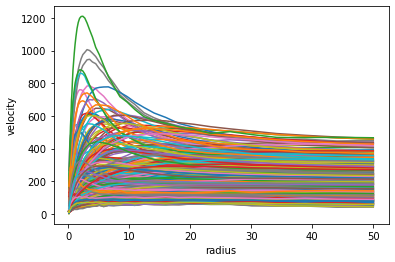

In [114]:
for v in datascale(vae.forward(xvalid),xmean,xstd): plt.plot(cm.rad, v.detach().numpy())
plt.xlabel('radius')
plt.ylabel('velocity');

In [116]:
msm, lvsm = vae.encoder(xtrain)[0].detach(), vae.encoder(xtrain)[1].detach()
# the above are the means and variances obtained by the encoder

ns = 100
sss = tensor(rng.normal(size=(ns, 4)), dtype=torch.float) * torch.exp(lvsm[0] * 0.5) + msm[0]
for i in range(1, msm.shape[0]):
    sss = torch.vstack((sss, tensor(rng.normal(size=(ns, 4)), dtype=torch.float) * torch.exp(lvsm[i] * 0.5) + msm[i]))
print (sss.shape)

torch.Size([160000, 4])


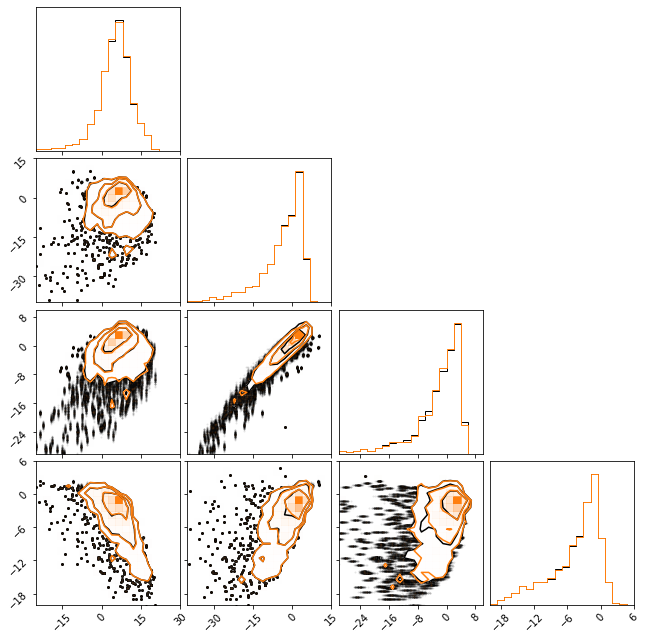

In [120]:
rr = ((-25,30),(-40,15),(-30,10),(-20,6))
fig = corner.corner(sss.numpy(), range=rr, hist_kwargs={"density":True});
fig = corner.corner(msm.numpy(), range=rr, color='C1', fig=fig, hist_kwargs={"density":True});

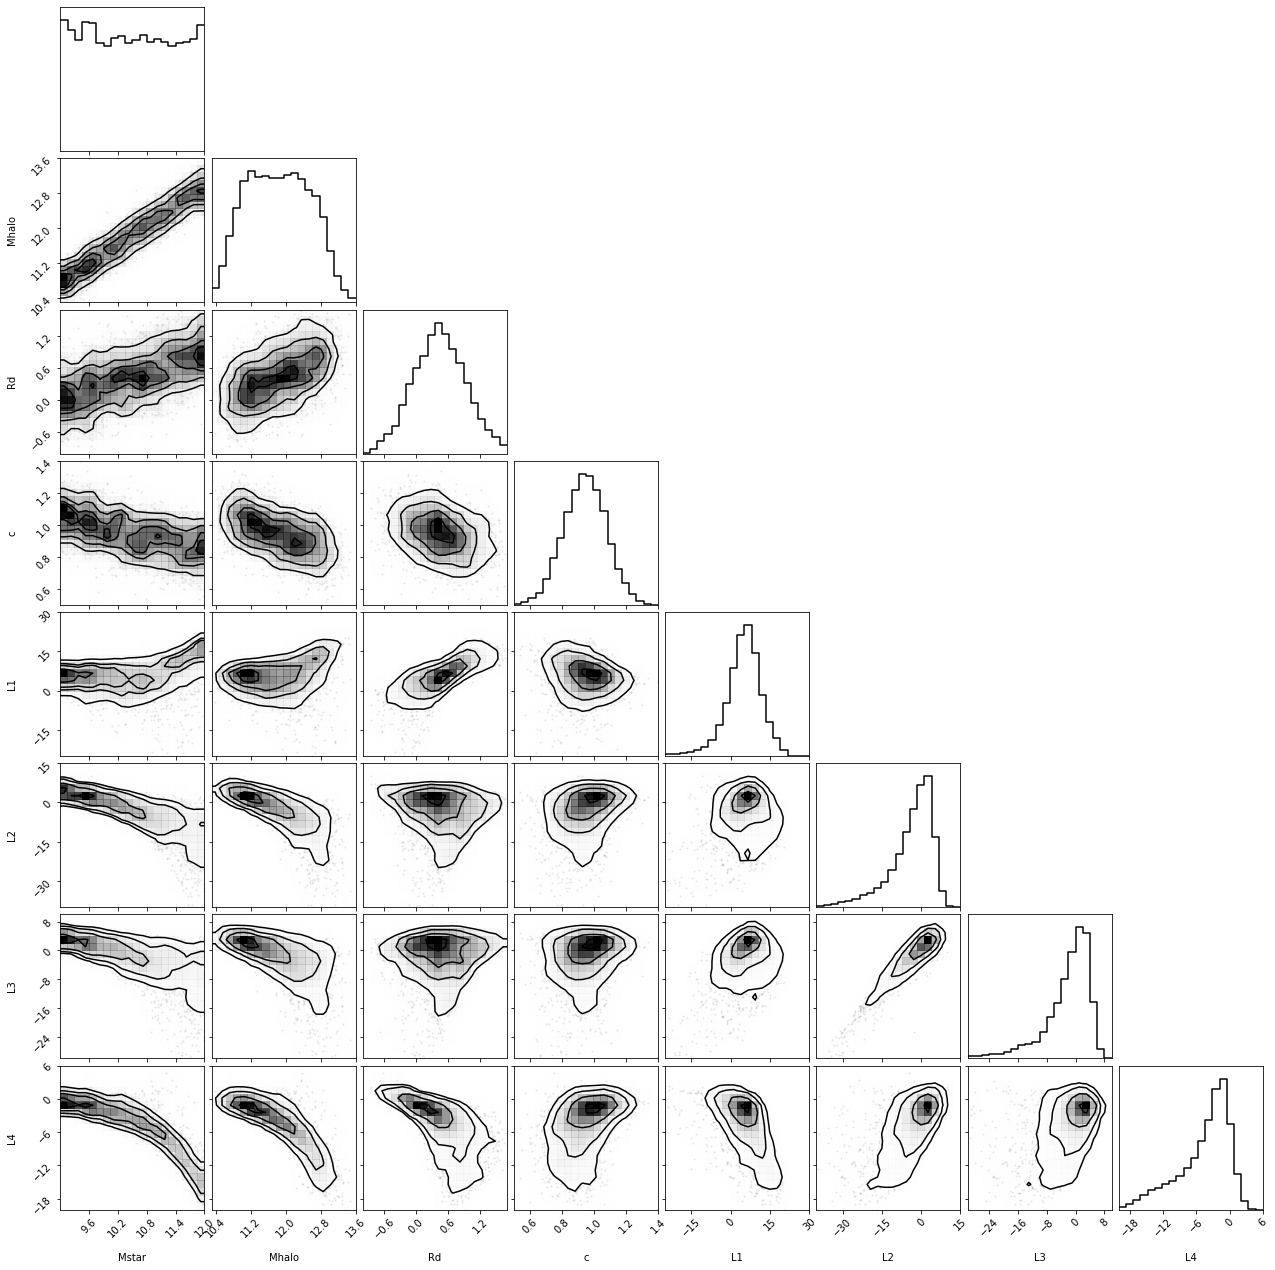

In [122]:
# stacking the tensor of phsyical parameters with that of the means derived by the encoder
dd = torch.hstack((torch.from_numpy(np.log10(partrain)), msm)).numpy()

rr = ((9,12),(10.3,13.6),(-1.0,1.7),(0.5,1.4),(-25,30),(-40,15),(-30,10),(-20,6))
ll = ['Mstar', 'Mhalo', 'Rd', 'c', 'L1', 'L2', 'L3', 'L4']
corner.corner(dd, range=rr, smooth=0.75, smooth1d=0.75, labels=ll);